# COVID-19 Chest X-Ray Classification

## Dataset Analysis

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import os

### Class Distribution

Count the number of images in each class to check for imbalance.

In [2]:
data_dir = './dataset'
classes = ['covid', 'lung-opacity', 'normal', 'viral-pneumonia']
for cls in classes:
    path = os.path.join(data_dir, cls)
    count = len(os.listdir(path))
    print(f"{cls}: {count} images")

covid: 3616 images
lung-opacity: 6012 images
normal: 10192 images
viral-pneumonia: 1345 images


**Observations:**
- Dataset is imbalanced: Normal class has most images (10,192), Viral Pneumonia has least (1,345)
- Total: 21,165 X-ray images across 4 classes
- Will need to handle class imbalance during training

### Sample Images from Each Class

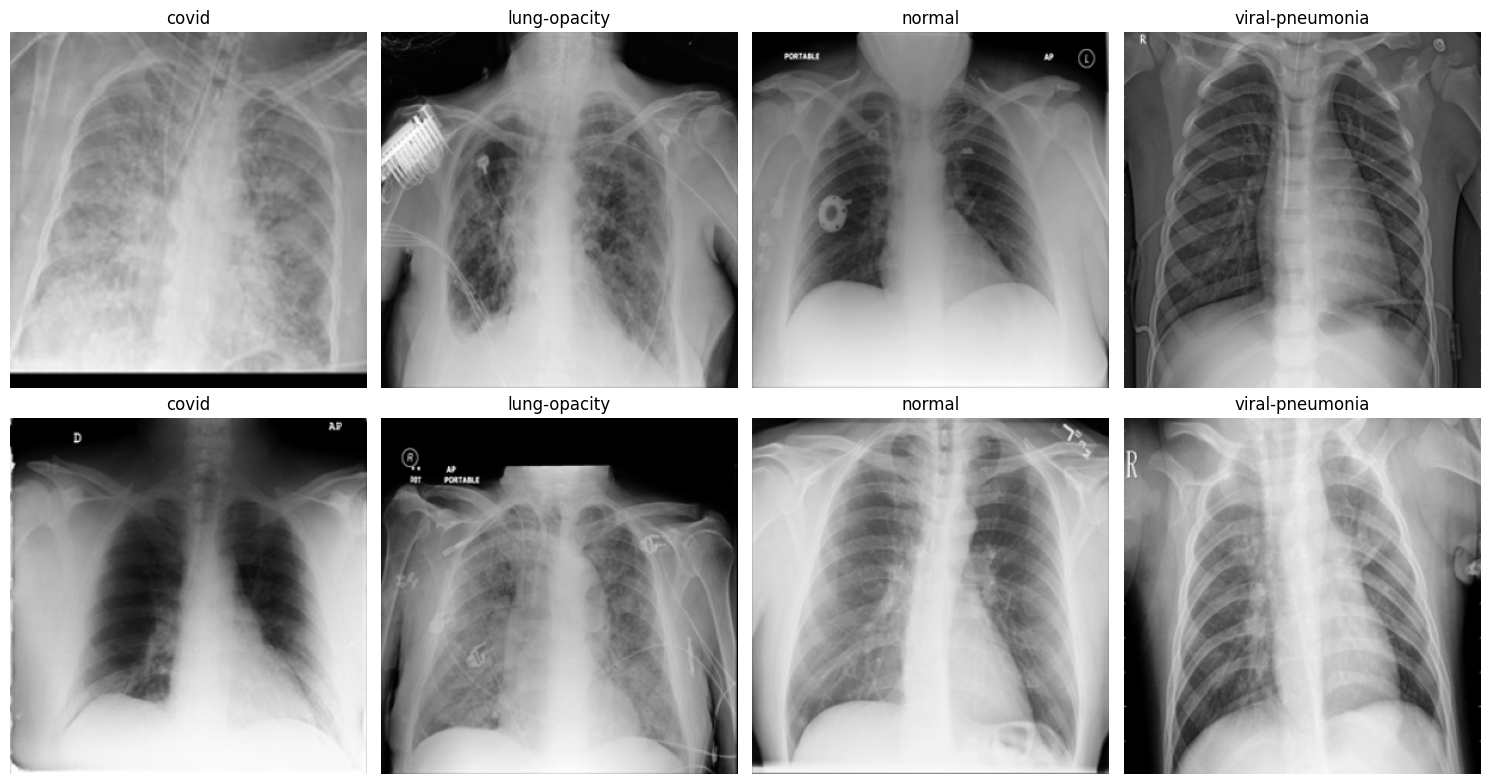

In [6]:
fig, axes = plt.subplots(2, 4, figsize=(15,8))

for i, cls in enumerate(classes):
    path = os.path.join(data_dir, cls)
    imgs = os.listdir(path)[:2]

    for j, img_name in enumerate(imgs):
        img = Image.open(os.path.join(path, img_name))
        axes[j, i].imshow(img, cmap='gray')
        axes[j, i].set_title(cls)
        axes[j, i].axis('off')

plt.tight_layout()
plt.show()